# Reconstruction-based anomaly detection

In most methods, anomaly detection is performed by training an autoencoder to recontruct an input image. The mean of the residual map (pixel wise difference) between an image $x$ and its reconstruction $\hat x$ (=MSE) is then thresholded to predict if there is any anomaly in $x$. This method also allows to segment the anomaly from the L2 residual map, again by using a threshold.

*AIM*: We want to investigate further this method and find other ways to detect an anomaly using $\hat x$ and $x$ which could be more refined than using a pixel wise difference.

*METHOD*: We use an already trained model which performs well on MNIST digits. We will introduce in the test set some digits with anomalies and some wihtout. The model will make predictions on the dataset and we will then predict (and segment when possible) the anomalies using different techniques:
1. DETECTION: threshold on MSE (referred to as L2 residual map). SEGMENTATION: Threshold on the L2 residual map to contour anomalies.
2. DETECTION: Kolmogorov-Smirnov test on the distribution of the pixel values in the original image and in the predictions.
3. SEGMENTATION: Local features of D

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

from scipy.ndimage import gaussian_filter

# !nvidia-smi

2.2.0


In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, -1).astype('float32') / 255.0
    
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [3]:
from MNIST_anomalies import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from MNIST_anomalies import plot_predictions

In [5]:
vae = tf.keras.models.load_model("UNet_model.pb")

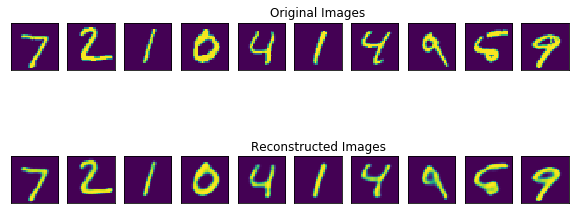

In [6]:
plot_predictions(vae, x_test, 10, dims=(28, 28, 1))

In [7]:
predictions, anomalies, anomalies_pred = predict_anomalies(vae, x_test, dims=(28, 28, 1))

In [17]:
def get_rm(im1, im2, rm_type="l2"):
    """
    rm_type: "l2" or "l1"
    Returns: Residual map and mean loss between im1, im2
    """
    if im1.shape == (28, 28, 1):
        im1 = np.squeeze(im1, axis=-1)
    if im2.shape == (28, 28, 1):
        im2 = np.squeeze(im2, axis=-1)
    if rm_type == "l2":
        rm = (im1 - im2) ** 2
    elif rm_type == "l1":
        rm = np.abs(im1 - im2)
    return rm, np.mean(rm)